# Structure Tensors

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from scipy.misc import imread
from scipy.misc import face
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


/home/francois/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


min val =  0.0  max val =  250.0


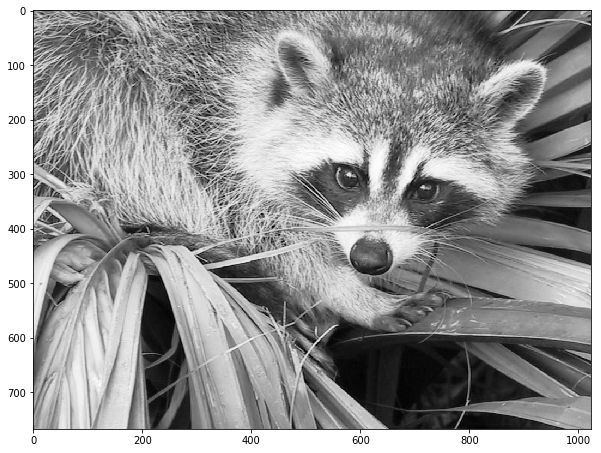

In [3]:
racoon = face(gray=True).astype(float)
# I normalize it to values between 0 and 1 to limit some graphics!
minr, maxr = racoon.min(), racoon.max()
print("min val = ", minr, " max val = ", maxr)
#racoon = (racoon - minr)/(maxr-minr)
plt.imshow(racoon, cmap=cm.Greys_r)
plt.show()

In [4]:
# Helper function that will draw arrows
NAN = float("NaN")
ARDATA = np.array([[0.0, 1.0, 0.9, NAN, 1.0, 0.9],[0.0, 0.0, 0.05, NAN, 0.0, -0.05]])

def drawarrow(start, end, ax, **kwargs):
    x0, y0 = start
    x1, y1 = end
    trans = np.array(start)
    trans.shape = (2,1)
    sx = x1-x0
    sy = y1-y0
    l = np.hypot(sx, sy)
    t = np.arctan2(sy, sx)
    ct = np.cos(t)
    st = np.sin(t)
    R = np.array([[ct, -st], [st, ct]])
    T = l*np.dot(R, ARDATA) + trans
    ax.plot(T[0], T[1], **kwargs)

## A procedute which compute the "flat" structure tensor for a (2n+1)x(2n+1) window around a given point and then generates a series of displays. 
### Be careful with indexing: when plotting images, the first dimension is the vertical one. When plotting points, lines (not over an image), this is the opposite.

In [5]:
def extract_flat_st_and_plot(img, cx, cy, n):
    # Plot the patch
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(img[cy-n:cy+n+1, cx-n:cx+n+1], cmap=cm.Greys_r, interpolation='none')
    x, y = np.mgrid[0:2*n+1, 0:2*n+1]
    
    # approximation of derivatives by central difference
    gx = (img[cy-n:cy+(n+1), cx-(n-1):cx+(n+2)] - racoon[cy-n:cy+(n+1), cx-(n+1):cx+n])
    gy = (racoon[cy-(n-1):cy+(n+2),cx-n:cx+(n+1)] - racoon[cy-(n+1):cy+n, cx-n:cx+(n+1)])
    m = np.arctan2(gy, gx)*np.hypot(gx, gy)
    ax.quiver(x,y, gx, gy, m, scale=1800)
    
    # make the (2n+1)x2 matrix of gradients, plot them as points
    gx.shape = (gx.size, 1)
    gy.shape = (gy.size, 1)
    A = np.hstack((gx, gy))
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(gx, gy, color='blue')
    
    # Computes the flat structure tensor A.TxA /(2n+1) and its eigendecomposition
    S = np.dot(A.T, A)/(2*n + 1)
    #print(S)
    val, vec = np.linalg.eigh(S)
    print("square-root of eigenvalues are ", np.sqrt(val))
    # could happen due to numerics?
    np.place(val, val < 0, 0.01)
    #print(val)
    #print(np.sqrt(np.abs(val)))
    start = (0,0)
    end1 = vec[:,0]*np.sqrt(val[0])
    end2 = vec[:,1]*np.sqrt(val[1])
    drawarrow(start, end1, ax, lw=2, color='red')
    drawarrow(start, end2, ax, lw=2, color='blue')
    ax.axis('equal')
    
    


## Extract the 81 gradients in a 9x9 window centered at point (y=300,x=575). The gradients are computed by finite difference

square-root of eigenvalues are  [ 131.67695711  151.38310881]


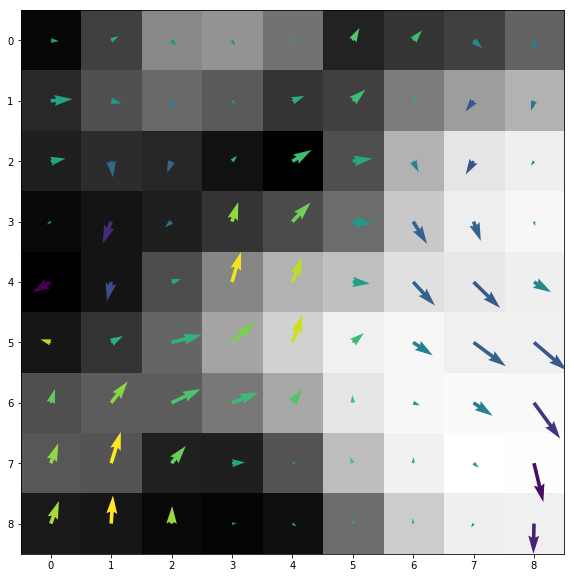

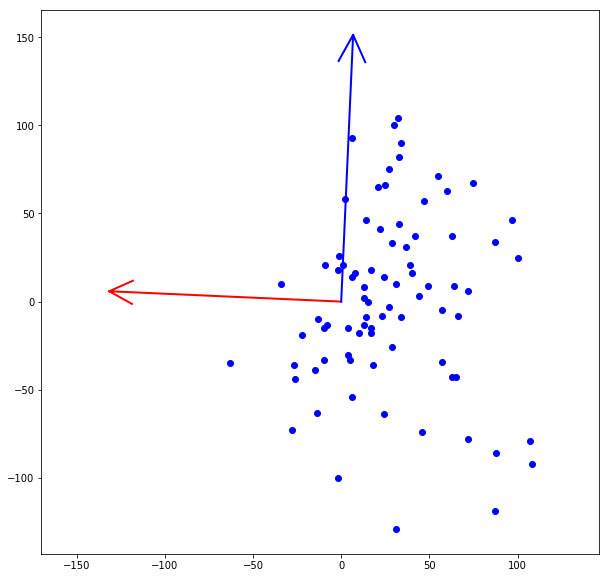

In [6]:
extract_flat_st_and_plot(racoon, cx=575, cy=300, n=4)


## Repeat the procedure at location (860, 495)

square-root of eigenvalues are  [ 4.96827128  7.9850313 ]


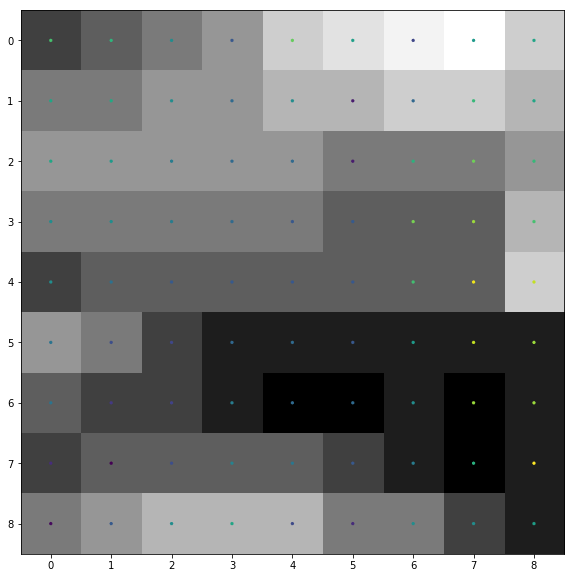

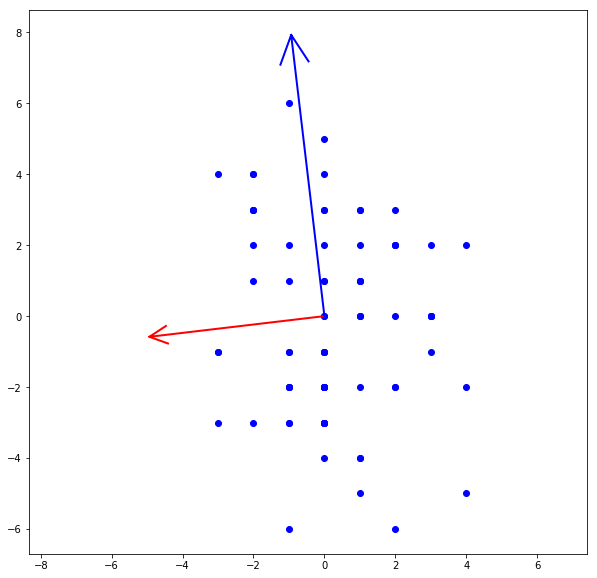

In [7]:
extract_flat_st_and_plot(racoon, cx=860, cy=495, n=4)

## Repeat the procedure at location (595, 771)

square-root of eigenvalues are  [  28.67014769  162.52630682]


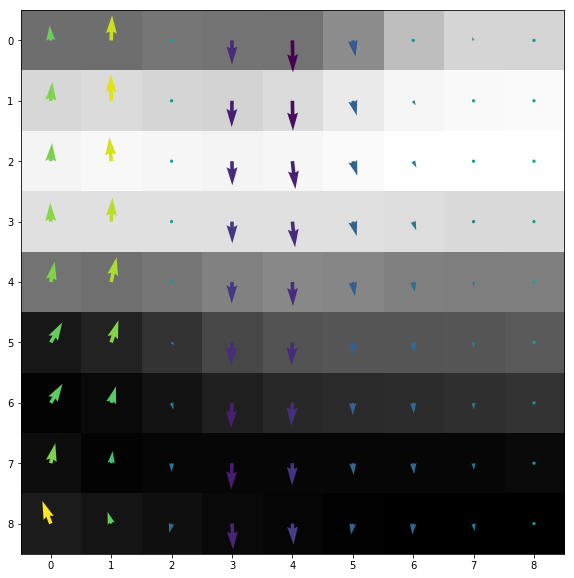

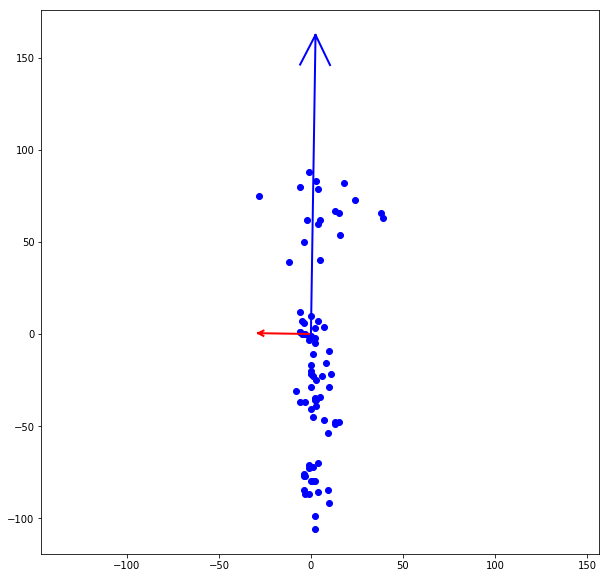

In [8]:
extract_flat_st_and_plot(racoon, cx=771, cy=595, n=4)

square-root of eigenvalues are  [  98.82118808  188.15518273]


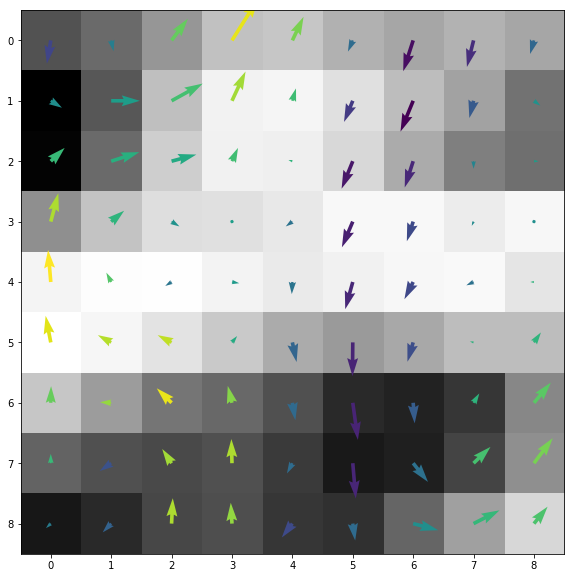

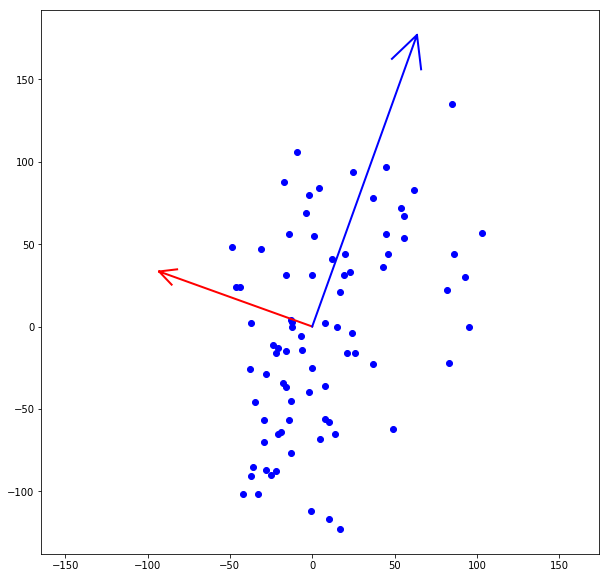

In [9]:
extract_flat_st_and_plot(racoon, cx=332, cy=265, n=4)

# Now with Gaussian weights related to distances to the center of the patch

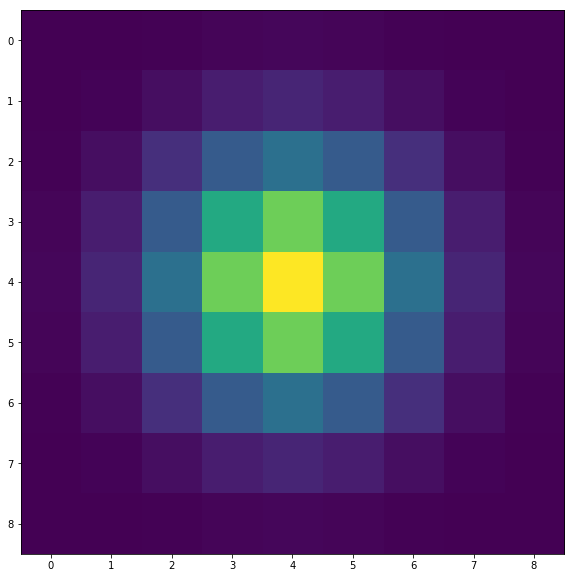

In [11]:
def truncated_gaussian(n, sigma):
    # for a (2n+1)x(2n+1) window
    x,y = np.mgrid[-n:n+1, -n:n+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g/np.sum(g)

g7 = np.sqrt(truncated_gaussian(4, 1.0))
plt.imshow(g7)
plt.show()

In [12]:
def extract_gaussian_st_and_plot(img, cx, cy, n, sigma):
    # Plot the patch
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(img[cy-n:cy+n+1, cx-n:cx+n+1], cmap=cm.Greys_r, interpolation='none')
    x, y = np.mgrid[0:2*n+1, 0:2*n+1]
    
    # Gaussian weight for distances
    w = np.sqrt(truncated_gaussian(n, sigma))
    
    # approximation of derivatives by central difference
    gx = (img[cy-n:cy+(n+1), cx-(n-1):cx+(n+2)] - racoon[cy-n:cy+(n+1), cx-(n+1):cx+n])
    gy = (racoon[cy-(n-1):cy+(n+2),cx-n:cx+(n+1)] - racoon[cy-(n+1):cy+n, cx-n:cx+(n+1)])
    wgx = gx*w
    wgy = gy*w
    m = np.arctan2(wgy, wgx)*np.hypot(wgx, wgy)
    ax.quiver(x,y, wgx, wgy, m, scale=300)
    
    # make the (2n+1)x2 matrix of gradients, plot them as points
   
    wgx.shape = (wgx.size, 1)
    wgy.shape = (wgy.size, 1)
    A = np.hstack((wgx, wgy))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(gx, gy, color='blue')
    
    # Computes the flat structure tensor A.TxA /(2n+1) and its eigendecomposition
    S = np.dot(A.T, A)
    val, vec = np.linalg.eigh(S)
    print("square-root of eigenvalues are", np.sqrt(val))
    start = (0,0)
    end1 = vec[:,0]*np.sqrt(val[0])
    end2 = vec[:,1]*np.sqrt(val[1])
    drawarrow(start, end1, ax, lw=2, color='red')
    drawarrow(start, end2, ax, lw=2, color='blue')
    ax.axis('equal')
    #print("Structure tensor matrix = ", S)

square-root of eigenvalues are [ 36.71358764  72.37566195]


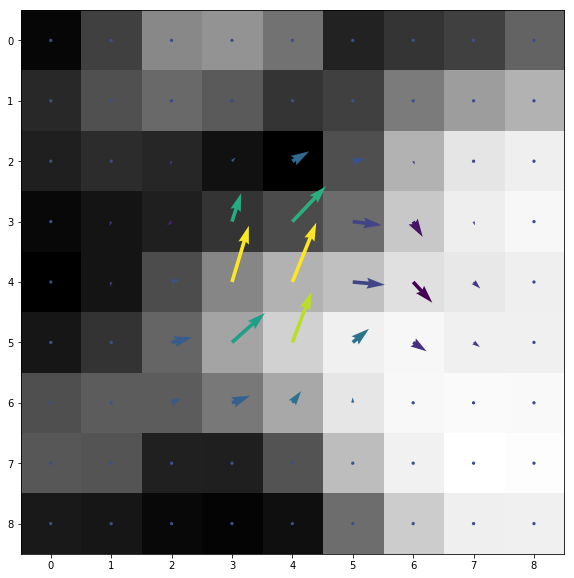

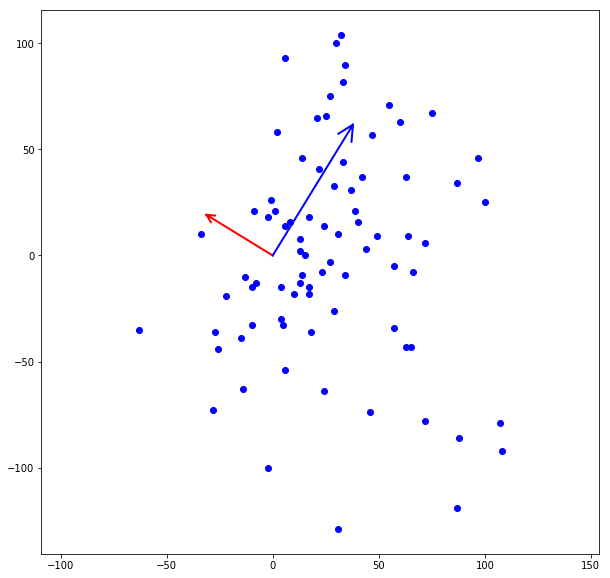

In [13]:
extract_gaussian_st_and_plot(racoon, cx=575, cy=300, n=4, sigma=1.0)

square-root of eigenvalues are [  9.55671403  54.17544157]


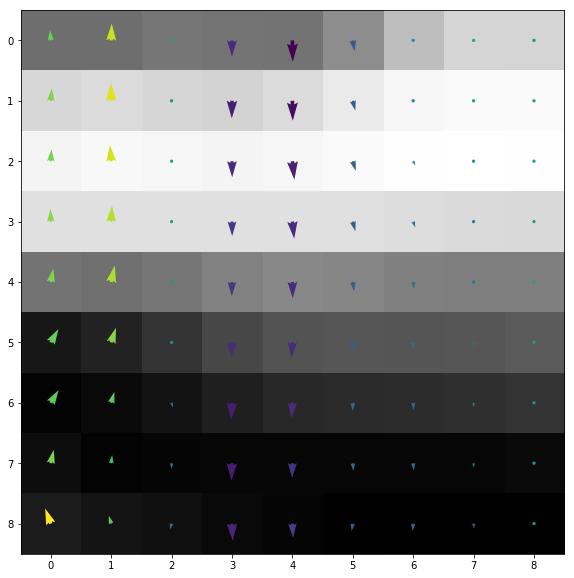

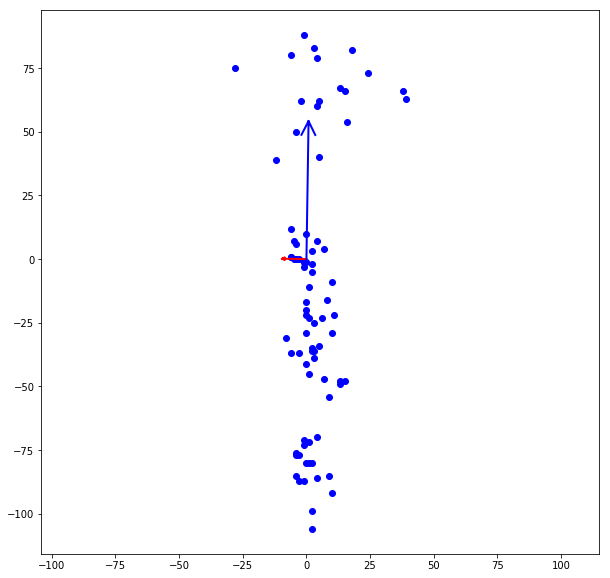

In [15]:
extract_gaussian_st_and_plot(racoon, cx=771, cy=595, n=4, sigma=2000.0)

In [ ]:
# The code for the structure_tensor function that I use (and have written) necessitates a series of 
# Python packages that are not normally installed. This is why I do not provide the scalespace module.

#from scalespace import structure_tensor, determinant_symmetric_field, trace_symmetric_field
#from scipy.ndimage import filters
#
#def get_harris(img, inscale, outscale, k, neighborhood_size, **kwargs):
#    strtens = structure_tensor(img, inscale, outscale)
#    harris = determinant_symmetric_field(strtens) - k*trace_symmetric_field(strtens)**2
#    locmax = filters.maximum_filter(harris, neighborhood_size)
#    maxima = (harris == locmax)
#    idx = np.where(maxima)
#    plt.imshow(img, cmap=cm.Greys_r)
#    ax = plt.gca()
#    ax.scatter(idx[1], idx[0], **kwargs)
#    plt.show()
#    
#get_harris(racoon, 1.0, 10.0, 0.1, 40, color='blue', alpha=0.65)